# Visualizing Data With Radar Charts in Python

Welcome! The purpose of this notebook is to provide several exemplar radar charts to demonstrate how they are created and illustrate some use cases where they can prove to be an insightful viz. Enjoy!

## Basic Setup

In [1]:
import datetime
# prints the present date and time as a form of log
print("This notebook was late run: ", datetime.datetime.now())

This notebook was late run:  2019-01-21 17:15:12.321974


In [2]:
# key basic packages
import pandas as pd
import numpy as np

# viz packages
import matplotlib.pyplot as plt
import pandas as pd
from math import pi

%matplotlib inline

## Importing and Cleaning the Data 

For this example, I'll be using a data extract pulled from the FT's MBA school rankings, [which you can find here.](http://rankings.ft.com/businessschoolrankings/global-mba-ranking-2018) I pulled these stats by picking that rankings I thought would be particularly relevant from their list of available data points. 

The question that all the exemplar visualizations below attempt to get at is simply **"how do the various top MBA programs (as of 2018) compare across different rankings (according to the FT)?"**

In [3]:
# importing the dataset which I cleaned up a bit manually in Excel after downloading it
base_mba_rankings_df = pd.read_csv(filepath_or_buffer = './data/ft_mba_2018_rankings.csv')

# inspecting the data
base_mba_rankings_df.head()

,School name,Rank in 2018,Value for money rank,Career progress rank,Careers service rank,Alumni recommend rank,FT research rank,Country
0,Stanford,1,70,4,31,2,5,US
1,Insead,2,6,19,64,6,9,France / Singapore
2,Wharton,3,98,17,15,4,1,US
3,London Business School,4,80,5,46,5,27,UK
4,Harvard,5,86,7,18,1,16,US


In [4]:
# conducting some basic cleaning with the help of the janitor package
from janitor import clean_names, remove_empty

# cleaning the column names and dropping any all-NULLs (precautionary)
clean_mba_rankings_df = (base_mba_rankings_df
          .clean_names(strip_underscores=True)
          .remove_empty()
          # also dropping country variable which I don't need for anything at the moment
          .drop(['country'], axis=1))

clean_mba_rankings_df.head()

,school_name,rank_in_2018,value_for_money_rank,career_progress_rank,careers_service_rank,alumni_recommend_rank,ft_research_rank
0,Stanford,1,70,4,31,2,5
1,Insead,2,6,19,64,6,9
2,Wharton,3,98,17,15,4,1
3,London Business School,4,80,5,46,5,27
4,Harvard,5,86,7,18,1,16


In [5]:
# more nuanced EDA 
# building a helpful function to look get info on the columns in our data frame
def dataframe_explorer(df):
    dict_list = []
    for col in df.columns:
        data = df[col]
        dict_ = {}
        # pulls the null count for a column
        dict_.update({'null_count' : data.isnull().sum()})
        # counts the unique values in a column
        dict_.update({'unique_count' : len(data.unique())})
        # gets the types of the data in a column
        dict_.update({'data_type' : data.dtype})
        dict_list.append(dict_)
            
    col_info_df = pd.DataFrame(dict_list)
    col_info_df.index = df.columns
    col_info_df.sort_values(by=['null_count','unique_count'], ascending=[True, False], inplace=True)
        
    return col_info_df

dataframe_explorer(clean_mba_rankings_df)

,data_type,null_count,unique_count
school_name,object,0,101
value_for_money_rank,int64,0,101
career_progress_rank,int64,0,101
careers_service_rank,int64,0,101
alumni_recommend_rank,int64,0,95
rank_in_2018,int64,0,88
ft_research_rank,int64,0,35


In [6]:
# we don't need any further null handling as can be seen from the df explorer results above
# inverting the sign of all ranks so that radar chart plotting is easier
# we need this bc radar plots plot larger numbers towards the edge
# but we want the higher ranks (i.e. top schools) towards the edge instead
# I do this by multiplying all columns with 'rank' in their name by -1

# checks for 'rank' in column name and then multiplies that col's contents by -1
clean_mba_rankings_df.loc[:,
                          (clean_mba_rankings_df.columns[
                              clean_mba_rankings_df.columns.str.contains(pat = 'rank')])
                         ] = (clean_mba_rankings_df.loc[:,
                          (clean_mba_rankings_df.columns[
                              clean_mba_rankings_df.columns.str.contains(pat = 'rank')])
                         ] * -1)

clean_mba_rankings_df.head()

,school_name,rank_in_2018,value_for_money_rank,career_progress_rank,careers_service_rank,alumni_recommend_rank,ft_research_rank
0,Stanford,-1,-70,-4,-31,-2,-5
1,Insead,-2,-6,-19,-64,-6,-9
2,Wharton,-3,-98,-17,-15,-4,-1
3,London Business School,-4,-80,-5,-46,-5,-27
4,Harvard,-5,-86,-7,-18,-1,-16


## Single Radar Chart

For documentation and an exemplar of a simple single radar chart, [check out this link here](https://python-graph-gallery.com/390-basic-radar-chart/).

For this single radar chart, we'll plot the overall rank for Stanford's MBA program at the top, and every other pole of the radar chart will represent the sub-ranks for the various categories. I chose Stanford because it is the number one ranked program according to these FT rankings.

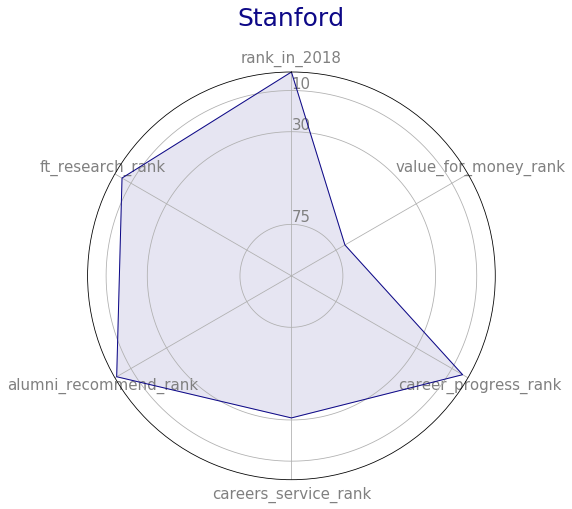

In [7]:
# setting default figure size and background color
plt.rcParams['figure.figsize'] = (7.5, 7.5)
plt.rcParams['figure.facecolor'] = 'white'

# creating a color palette to use for this chart
# the second parameter should be the number of colors you need, so here 1
my_palette = plt.cm.get_cmap("plasma", 1)
 
# number of variables
categories=list(clean_mba_rankings_df)[1:]
N = len(categories)
 
# we start by plotting the first line of the data frame
# we need to repeat the first value to close the circular graph
values=clean_mba_rankings_df.loc[0].drop(['school_name']).values.flatten().tolist()
values += values[:1]
 
# we then find the angle of each axis in the plot
# to do this we divide the plot / number of variables
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# initialize the spider plot
ax = plt.subplot(111, polar=True)

# include 2 lines below if you want the first axis to be on top
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# draw one axis per variable
plt.xticks(angles[:-1], categories, color='grey', size=10)
 
# draw ylabels and set label size
ax.set_rlabel_position(0)
plt.yticks([-75,-30,-10], ["75","30","10"], color="grey", size=15)
plt.ylim(-100,-1)
# this controls the size of the labels
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(15)

# add a title
# the larger your 'y' param, the greater the vertical separation between chart and title
plt.title(clean_mba_rankings_df['school_name'][0], size=25, color=my_palette(1), y=1.1)
 
# plot data
ax.plot(angles, values, linewidth=1, linestyle='solid', color=my_palette(0))
    
# fill area
ax.fill(angles, values, 'b', alpha=0.1, color=my_palette(1))

# save the figure as well
plt.savefig('output_viz/stanford.png')

# show chart
plt.show()

## Overlayed Radar Charts

For documentation and an exemplar of simple overlayed radar charts, [check out this link here](https://python-graph-gallery.com/391-radar-chart-with-several-individuals/).

For this multi-member single radar chart, I chose to go with the same overall structure as the single radar chart above, but this time overlaying Stanford and INSEAD--the two top MBA programs--for comparison. 

**Note:** I personally think that with any more than 2 (sometimes maybe 3-4 at the most) overlayed radar charts, things become unreadable, so if you want to compare many populations with this structure, I'd recommend going with the facetted method shown in the next section below. 



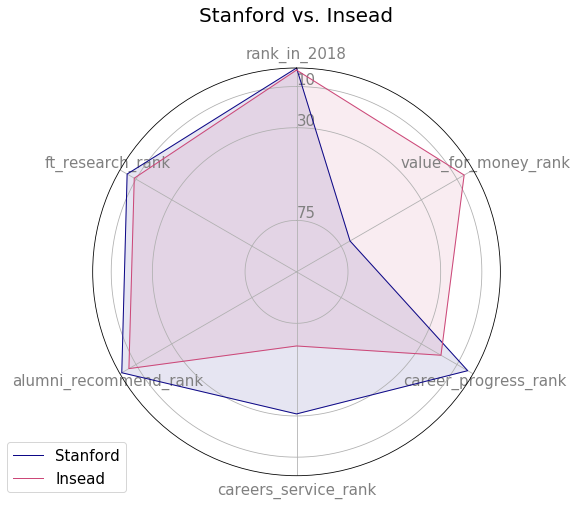

In [8]:
# ------- PART 1: Create background

# setting default figure size and background color
plt.rcParams['figure.figsize'] = (7.5, 7.5)
plt.rcParams['figure.facecolor'] = 'white'

# creating a color palette to use for this chart
# the second parameter should be the number of colors you need
# normally, then, I'd pick 2, but the 3 color palette is prettier w/ plasma
# because the default 1st pick in a 2-color palette is a bright yellow
my_palette = plt.cm.get_cmap("plasma", 3)
 
# number of variables
categories=list(clean_mba_rankings_df)[1:]
N = len(categories)
 
# we then find the angle of each axis in the plot
# to do this we divide the plot / number of variables
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# initialize the spider plot
ax = plt.subplot(111, polar=True)

# include 2 lines below if you want the first axis to be on top
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# draw one axis per variable
plt.xticks(angles[:-1], categories, color='grey', size=10)
 
# draw ylabels and set label size
ax.set_rlabel_position(0)
plt.yticks([-75,-30,-10], ["75","30","10"], color="grey", size=15)
plt.ylim(-100,-1)
# this controls the size of the labels
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(15)
 
# ------- PART 2: Add plots
 
# one code block below for each 'individual' -- each population to be overlayed
# no loop because as explained above you generally don't want a lot of these
 
# plot for individual # 1
values=clean_mba_rankings_df.loc[0].drop('school_name').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label=clean_mba_rankings_df.iloc[0,0], color=my_palette(0))
ax.fill(angles, values, 'b', alpha=0.1, color=my_palette(0))
 
# plot for individual # 2
values=clean_mba_rankings_df.loc[1].drop('school_name').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label=clean_mba_rankings_df.iloc[1,0], color=my_palette(1))
ax.fill(angles, values, 'r', alpha=0.1, color=my_palette(1))

# add a title
# the larger your 'y' param, the greater the vertical separation between chart and title
plt.title(
    (clean_mba_rankings_df['school_name'][0] + " vs. " + clean_mba_rankings_df['school_name'][1]), 
    size=20, y=1.1
)
 
# add legend; 1st param is location, prop here modulates only size
plt.legend(bbox_to_anchor=(0.1, 0.1), prop={'size': 15})

# save the figure as well
plt.savefig('output_viz/stanford_vs_insead.png')

# display the plot
plt.show()

## Multiple Radar Charts Using Faceting

For documentation and an exemplar of multiple radar charts using faceting, [check out this link here](https://python-graph-gallery.com/392-use-faceting-for-radar-chart/). 

For this example, I chose to simply expand the list of schools for which I plot rank info from 2 to 4, giving each of the top 4 MBA programs their own chart.

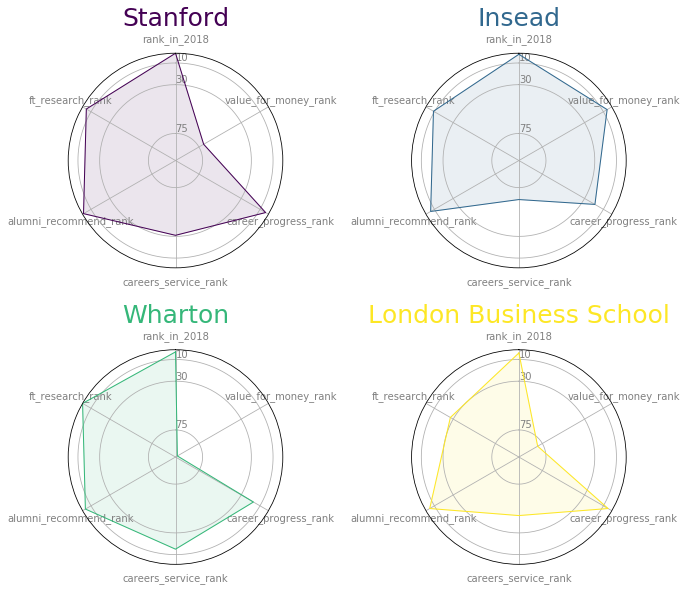

In [9]:
# ------- PART 1: Define a function that does a plot for one line of the dataset!
 
def make_spider(row, title, color):
 
    # number of variables
    categories=list(clean_mba_rankings_df)[1:]
    N = len(categories)
 
    # we then find the angle of each axis in the plot
    # to do this we divide the plot / number of variables
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # initialize the spider plot
    ax = plt.subplot(2,2,row+1, polar=True)
    
    # increase whitespace between plots so they don't overlap
    plt.subplots_adjust(wspace = 0.6)

    # include 2 lines below if you want the first axis to be on top
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # draw one axis per variable
    plt.xticks(angles[:-1], categories, color='grey', size=10)

    # draw ylabels and set label size
    ax.set_rlabel_position(0)
    plt.yticks([-75,-30,-10], ["75","30","10"], color="grey", size=15)
    plt.ylim(-100,-1)
    # this controls the size of the labels
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(10)

    # plot for individual
    values=clean_mba_rankings_df.loc[row].drop('school_name').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=clean_mba_rankings_df.iloc[row,0], color=my_palette(row))
    ax.fill(angles, values, 'r', alpha=0.1, color=my_palette(row))

    # add a title
    # the larger your 'y' param, the greater the vertical separation between chart and title
    plt.title(title, size=25, color=color, y=1.1)

# setting default figure size and background color
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['figure.facecolor'] = 'white'

# creating a color palette to use for this chart
# the second parameter should be the number of colors you need, so here 2
my_palette = plt.cm.get_cmap("viridis", 4)
 
# Loop to plot the top 4 schools (by overall rank)
for row in range(0, 4):
    make_spider(row=row, title=clean_mba_rankings_df['school_name'][row], color=my_palette(row))
    
# save the figure as well
plt.savefig('output_viz/top_4_schools.png')

# display the plot
plt.show()

## Functionalizing Chart Radar Chart Creation

Lastly, I wanted to show a simple example of how you could easily functionalize this whole process by creating a function that takes in two row numbers (good approximate for overall rank), and returns a comparison plot of the two schools with those ranks.

In [10]:
def comparative_radar_builder(row_number_1 = 1, row_number_2 = 2):
    
    """Take in any two ranks and return a radar chart comparing the subranks of the schools with those ranks.
 
     Keyword arguments:
        row_number_1 -- row number of 1st university for comparison.
        row_number_2 -- row number of 2nd university for comparison.
 
    """
    
    # setting default figure size and background color
    plt.rcParams['figure.figsize'] = (7.5, 7.5)
    plt.rcParams['figure.facecolor'] = 'white'

    # creating a color palette to use for this chart
    # the second parameter should be the number of colors you need, so here 2
    my_palette = plt.cm.get_cmap("plasma", 3)
    
    # number of variables
    categories=list(clean_mba_rankings_df)[1:]
    N = len(categories)

    # we then find the angle of each axis in the plot
    # to do this we divide the plot / number of variables
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # initialize the spider plot
    ax = plt.subplot(111, polar=True)

    # include 2 lines below if you want the first axis to be on top
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # draw one axis per variable
    plt.xticks(angles[:-1], categories, color='grey', size=10)

    # draw ylabels and set label size
    ax.set_rlabel_position(0)
    plt.yticks([-75,-30,-10], ["75","30","10"], color="grey", size=15)
    plt.ylim(-100,-1)
    # this controls the size of the labels
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(15)

    # ------- PART 2: Add plots

    # one code block below for each 'individual' -- each population to be overlayed
    # no loop because as explained above you generally don't want a lot of these

    # plot for individual # 1
    values=clean_mba_rankings_df.loc[row_number_1-1].drop('school_name').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=clean_mba_rankings_df.iloc[row_number_1-1,0], color=my_palette(0))
    ax.fill(angles, values, 'b', alpha=0.1, color=my_palette(0))

    # plot for individual # 2
    values=clean_mba_rankings_df.loc[row_number_2-1].drop('school_name').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=clean_mba_rankings_df.iloc[row_number_2-1,0], color=my_palette(1))
    ax.fill(angles, values, 'r', alpha=0.1, color=my_palette(1))

    # add a title
    # the larger your 'y' param, the greater the vertical separation between chart and title
    plt.title(
        (clean_mba_rankings_df['school_name'][row_number_1-1] + " vs. " + clean_mba_rankings_df['school_name'][row_number_2-1]), 
        size=20, y=1.1
    )

    # add legend; 1st param is location, prop here modulates only size
    plt.legend(bbox_to_anchor=(0.1, 0.1), prop={'size': 15})

    # save the figure as well
    plt.savefig('output_viz/comparative_plot_ex.png')

    # display the plot
    plt.show()

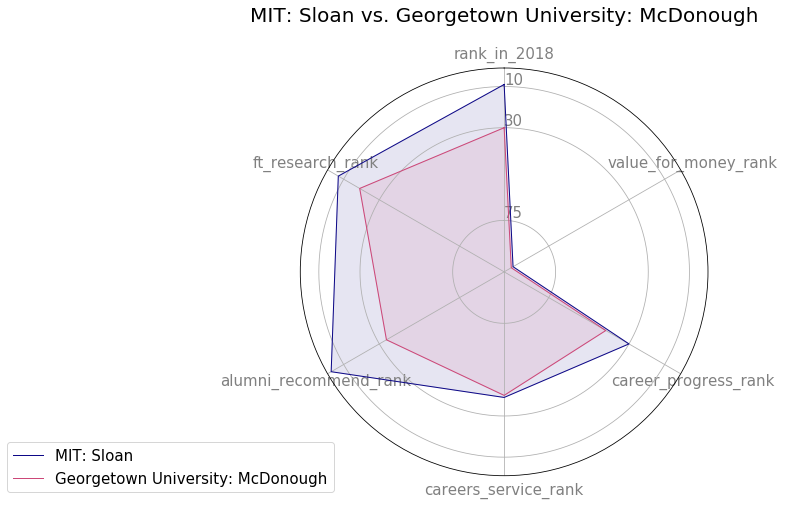

In [11]:
# testing the function with random schools not in top 5
comparative_radar_builder(9,30)